In [1]:
import torch
import neml2
from pyzag import nonlinear, chunktime
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
import os
from scipy.interpolate import interp1d
import numpy as np

In [2]:
torch.set_default_dtype(torch.double)
if torch.cuda.is_available():
    dev = "cuda:0"
    print("CUDA is available")
    print(f"CUDA version: {torch.version.cuda}")
else:
    dev = "cpu"
    print("CUDA is not available")
device = torch.device(dev)

CUDA is available
CUDA version: 12.8


--- Stress-Temperature Mapping ---
873K_66MPa: 66 MPa, 600C
823K_121MPa: 121 MPa, 550C
773K_363MPa: 363 MPa, 500C
873K_105MPa: 105 MPa, 600C
823K_227MPa: 227 MPa, 550C


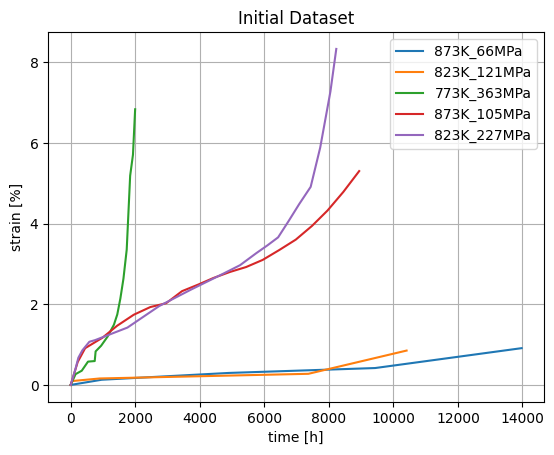

In [3]:
path = '/home/colinmoose/neml2/cmg_projects/creep_data'
data_frames = {}
stress_temp_map = {}
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    df = pd.read_csv(file_path)
    if '66' in filename:
        stress_label = '873K_66MPa'
        stress_temp_map[stress_label] = (66, 873 - 273)
    if '105' in filename:
        stress_label = '873K_105MPa'
        stress_temp_map[stress_label] = (105, 873 - 273)
    if '121' in filename:
        stress_label = '823K_121MPa'
        stress_temp_map[stress_label] = (121, 823 - 273)
    if '227' in filename:
        stress_label = '823K_227MPa'
        stress_temp_map[stress_label] = (227, 823 - 273)
    if '363' in filename:
        stress_label = '773K_363MPa'
        stress_temp_map[stress_label] = (363, 773 - 273)
    new_df = df.rename(columns={'x':f'{stress_label}_time', 'y':f'{stress_label}_strain'})
    data_frames[stress_label] = new_df

strain_data = {}
time_data = {}

for stress_label, df in data_frames.items():
    time_col = f'{stress_label}_time'
    strain_col = f'{stress_label}_strain'
    time = torch.tensor(df[time_col].values, device=device)
    strain = torch.tensor(df[strain_col].values, device=device)
    time = time[:] - time[0]
    strain = strain[:] - strain[0]
    time_data[stress_label] = time
    strain_data[stress_label] = strain

print("--- Stress-Temperature Mapping ---")
for label, (stress, temp) in stress_temp_map.items():
    print(f'{label}: {stress} MPa, {temp}C')

plt.figure()
for stress_label in strain_data:
    plt.plot(time_data[stress_label].cpu().numpy(), strain_data[stress_label].cpu().numpy(), label=f'{stress_label}')
plt.xlabel('time [h]')
plt.ylabel('strain [%]')
plt.title('Initial Dataset')
plt.legend()
plt.grid()
plt.show()

In [5]:
nbatch = 5  # Number of actual experimental conditions
ntime = 100
exp_conditions = [
    ('873K_66MPa', 66, 600),
    ('873K_105MPa', 105, 600),
    ('823K_121MPa', 121, 550),
    ('823K_227MPa', 227, 550),
    ('773K_363MPa', 363, 500)
]
for batch_idx, (label, stress, temperature) in enumerate(exp_conditions):
    print(f"{label}: {stress} MPa, {temperature}C")

873K_66MPa: 66 MPa, 600C
873K_105MPa: 105 MPa, 600C
823K_121MPa: 121 MPa, 550C
823K_227MPa: 227 MPa, 550C
773K_363MPa: 363 MPa, 500C


873K_66MPa time range: [0.0, 13975.054229934922]
873K_66MPa: Ramp ends at index 0, time = 0.0000 hours
  First few points:
    t[0] = 0.0000 hours, stress = 0.0000 MPa
    t[1] = 141.1622 hours, stress = 66.0000 MPa
873K_105MPa time range: [0.0, 8941.048034934496]
873K_105MPa: Ramp ends at index 0, time = 0.0000 hours
  First few points:
    t[0] = 0.0000 hours, stress = 0.0000 MPa
    t[1] = 90.3136 hours, stress = 105.0000 MPa
823K_121MPa time range: [0.0, 10410.199556541025]
823K_121MPa: Ramp ends at index 0, time = 0.0000 hours
  First few points:
    t[0] = 0.0000 hours, stress = 0.0000 MPa
    t[1] = 105.1535 hours, stress = 121.0000 MPa
823K_227MPa time range: [0.0, 8231.292517006803]
823K_227MPa: Ramp ends at index 0, time = 0.0000 hours
  First few points:
    t[0] = 0.0000 hours, stress = 0.0000 MPa
    t[1] = 83.1444 hours, stress = 227.0000 MPa
773K_363MPa time range: [0.0, 1997.1910112359556]
773K_363MPa: Ramp ends at index 0, time = 0.0000 hours
  First few points:
    t[

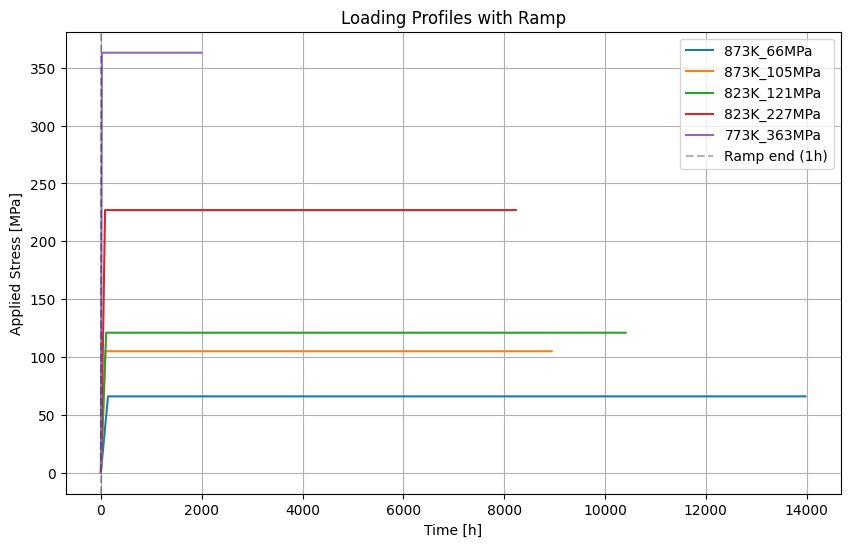

In [6]:
time = torch.zeros((ntime, nbatch, 1), device=device)
loading = torch.zeros((ntime, nbatch, 6), device=device)
temperature = torch.zeros((ntime, nbatch, 1), device=device)

for batch_idx, (label, stress_val, temp_val) in enumerate(exp_conditions):
    min_time = time_data[label].min().item()
    max_time = time_data[label].max().item()

    print(f"{label} time range: [{min_time}, {max_time}]")

    time_values = torch.linspace(min_time, max_time, ntime, device=device)
    time[:, batch_idx, 0] = time_values
    temperature[:, batch_idx, 0] = temp_val

    ramp_time = 1.0
    ramp_fraction = torch.clamp(time_values/ramp_time, 0.0, 1.0)
    loading[:, batch_idx, 0] = stress_val * ramp_fraction

    ramp_idx = (time_values <= ramp_time).sum().item()
    if ramp_idx > 0:
        print(f"{label}: Ramp ends at index {ramp_idx-1}, time = {time_values[ramp_idx-1]:.4f} hours")
    else:
        print(f"{label}: No ramp (min_time > {ramp_time})")

    print(f"  First few points:")
    for i in range(min(2, len(time_values))):
        print(f"    t[{i}] = {time_values[i]:.4f} hours, stress = {loading[i, batch_idx, 0]:.4f} MPa")

print(f"\n--- Full Input Tensors ---\ntime:\n{time.shape}\ntemperature:\n{temperature.shape}\nloading:\n{loading.shape}")
plt.figure(figsize=(10, 6))
for batch_idx, (label, stress_val, temp_val) in enumerate(exp_conditions):
    plt.plot(time[:, batch_idx, 0].cpu().numpy(), 
             loading[:, batch_idx, 0].cpu().numpy(), 
             label=f"{label}")
plt.xlabel('Time [h]')
plt.ylabel('Applied Stress [MPa]')
plt.title('Loading Profiles with Ramp')
plt.axvline(x=ramp_time, color='k', linestyle='--', alpha=0.3, label='Ramp end (1h)')
plt.legend()
plt.grid()
plt.show()

Initial data size for 773K_363MPa:
torch.Size([6])
Initial data size for 773K_363MPa:
torch.Size([5])
Initial data size for 773K_363MPa:
torch.Size([16])
Initial data size for 773K_363MPa:
torch.Size([20])
Initial data size for 773K_363MPa:
torch.Size([20])
Interpolated data for 873K_66MPa:
Stress: 66 MPa, Temperature: 600C
Batch index: 0
  Time range: [0.0000, 13975.0542]
  Strain range: [0.0000, 0.9109]
Interpolated data for 873K_105MPa:
Stress: 105 MPa, Temperature: 600C
Batch index: 1
  Time range: [0.0000, 8941.0480]
  Strain range: [0.0000, 5.2989]
Interpolated data for 823K_121MPa:
Stress: 121 MPa, Temperature: 550C
Batch index: 2
  Time range: [0.0000, 10410.1996]
  Strain range: [0.0000, 0.8512]
Interpolated data for 823K_227MPa:
Stress: 227 MPa, Temperature: 550C
Batch index: 3
  Time range: [0.0000, 8231.2925]
  Strain range: [0.0000, 8.3263]
Interpolated data for 773K_363MPa:
Stress: 363 MPa, Temperature: 500C
Batch index: 4
  Time range: [0.0000, 1997.1910]
  Strain range:

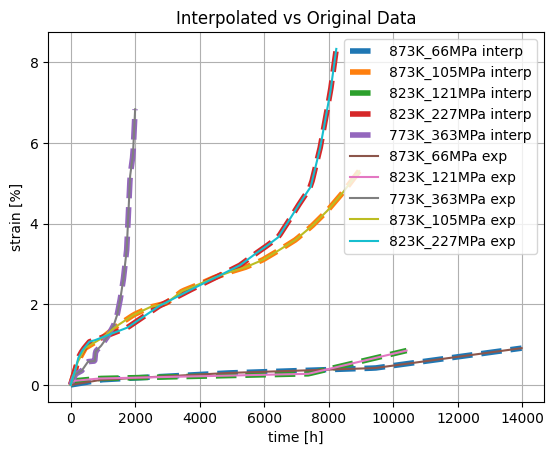

In [7]:
for stress_label in time_data:
    print(f"Initial data size for {label}:\n{time_data[stress_label].shape}")

exp_time_data = torch.zeros_like(loading, device=device)
exp_strain_data = torch.zeros_like(loading, device=device)

plt.figure()
for batch_idx, (label, stress_val, temp_val) in enumerate(exp_conditions):
    min_time = time_data[label].min().item()
    max_time = time_data[label].max().item()

    time_values = torch.linspace(min_time, max_time, ntime, device=device)

    f_strain = interp1d(time_data[label].cpu().numpy(), strain_data[label].cpu().numpy(),kind='linear')
    interp_strain = f_strain(time_values.cpu().numpy())
    exp_strain_data[:, batch_idx, 0] = torch.tensor(interp_strain, device=device)
    exp_time_data[:, batch_idx, 0] = time_values

    print(f"Interpolated data for {label}:")
    print(f"Stress: {stress_val} MPa, Temperature: {temp_val}C")
    print(f"Batch index: {batch_idx}")
    print(f"  Time range: [{exp_time_data[:, batch_idx, 0].min():.4f}, {exp_time_data[:, batch_idx, 0].max():.4f}]")
    print(f"  Strain range: [{exp_strain_data[:, batch_idx, 0].min():.4f}, {exp_strain_data[:, batch_idx, 0].max():.4f}]")
    plt.plot(exp_time_data[:, batch_idx, 0].cpu().numpy(), exp_strain_data[:, batch_idx, 0].cpu().numpy(),'--',lw=4, label=f"{label} interp")
print("--- Interpolated Data Tensors ---")
print(f"exp time data: {exp_time_data.shape}")
print(f"exp strain data: {exp_strain_data.shape}")


for stress_label in strain_data:
    plt.plot(time_data[stress_label].cpu().numpy(), strain_data[stress_label].cpu().numpy(), label=f'{stress_label} exp')
plt.xlabel('time [h]')
plt.ylabel('strain [%]')
plt.title('Interpolated vs Original Data')
plt.grid()
plt.legend()
plt.show()

In [8]:
class SolveStrain(torch.nn.Module):
    """Just integrate the model through some strain history

    Args:
        discrete_equations: the pyzag wrapped model
        nchunk (int): number of vectorized time steps
        rtol (float): relative tolerance to use for Newton's method during time integration
        atol (float): absolute tolerance to use for Newton's method during time integration
    """

    def __init__(self, discrete_equations, nchunk=1, rtol=1.0e-6, atol=1.0e-4):
        super().__init__()
        self.discrete_equations = discrete_equations
        self.nchunk = nchunk
        self.rtol = rtol
        self.atol = atol

    def forward(self, time, temperature, loading):
        """Integrate through some time/temperature/strain history and return stress
        Args:
            time (torch.tensor): batched times
            temperature (torch.tensor): batched temperatures
            loading (torch.tensor): loading conditions, which are the input strain in the first base index and then the stress (zero) in the remainder
        """
        solver = nonlinear.RecursiveNonlinearEquationSolver(
            self.discrete_equations,
            step_generator=nonlinear.StepGenerator(self.nchunk),
            predictor=nonlinear.PreviousStepsPredictor(),
            nonlinear_solver=chunktime.ChunkNewtonRaphson(rtol=self.rtol, atol=self.atol),
        )
        
        control = torch.ones_like(loading)

        # Setup
        forces = self.discrete_equations.forces_asm.assemble_by_variable(
            {
                "forces/t": time,
                "forces/control": control,
                "forces/T": temperature,
                "forces/fixed_values": loading
            }
        ).torch()
        state0 = torch.zeros(
            forces.shape[1:-1] + (self.discrete_equations.nstate,), device=forces.device
        )

        result = nonlinear.solve_adjoint(solver, state0, len(forces), forces)
        
        # Check if result is empty or invalid
        if result is None or len(result) == 0:
            raise RuntimeError("Solver returned empty result - integration failed")

        return result[...,0:1]

In [9]:

nchunk = 25
nmodel = neml2.load_model("test_model2.i", "implicit_rate")
nmodel.to(device = device)
print(nmodel)
model = SolveStrain(neml2.pyzag.NEML2PyzagModel(nmodel, exclude_parameters = ["E_X", "E_Y", "elasticity_nu", "R_X", "d_X", "sy_X", "mu_X", "n_X"]))

Name:       implicit_rate
Input:      forces/T [Scalar]
            forces/control [SR2]
            forces/fixed_values [SR2]
            forces/t [Scalar]
            old_forces/control [SR2]
            old_forces/fixed_values [SR2]
            old_forces/t [Scalar]
            old_state/internal/ep [Scalar]
            old_state/mixed_state [SR2]
            state/internal/ep [Scalar]
            state/mixed_state [SR2]
Output:     residual/internal/ep [Scalar]
            residual/mixed_state [SR2]
Parameters: E_X [Scalar][Double][cuda:0]
            E_Y [Scalar][Double][cuda:0]
            R_X [Scalar][Double][cuda:0]
            R_Y [Scalar][Double][cuda:0]
            d_X [Scalar][Double][cuda:0]
            d_Y [Scalar][Double][cuda:0]
            elasticity_nu [Scalar][Double][cuda:0]
            mu_X [Scalar][Double][cuda:0]
            mu_Y [Scalar][Double][cuda:0]
            n_X [Scalar][Double][cuda:0]
            n_Y [Scalar][Double][cuda:0]
            sy_X [Scalar][Do

In [10]:
with torch.no_grad():
    data = model(time, temperature, loading)
print(f"{data}\n{data.shape}")

tensor([[[0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0010],
         [0.0016],
         [0.0018],
         [0.0033],
         [0.0050]],

        [[0.0010],
         [0.0016],
         [0.0018],
         [0.0033],
         [0.0050]],

        [[0.0010],
         [0.0016],
         [0.0018],
         [0.0033],
         [0.0050]],

        [[0.0010],
         [0.0016],
         [0.0018],
         [0.0033],
         [0.0050]],

        [[0.0010],
         [0.0016],
         [0.0018],
         [0.0033],
         [0.0050]],

        [[0.0010],
         [0.0016],
         [0.0018],
         [0.0033],
         [0.0050]],

        [[0.0010],
         [0.0016],
         [0.0018],
         [0.0033],
         [0.0050]],

        [[0.0010],
         [0.0016],
         [0.0018],
         [0.0033],
         [0.0050]],

        [[0.0010],
         [0.0016],
         [0.0018],
         [0.0033],
         [0.0050]],

        [[0.0010],
         [0